# Лабораторная работа №4

## Задание:

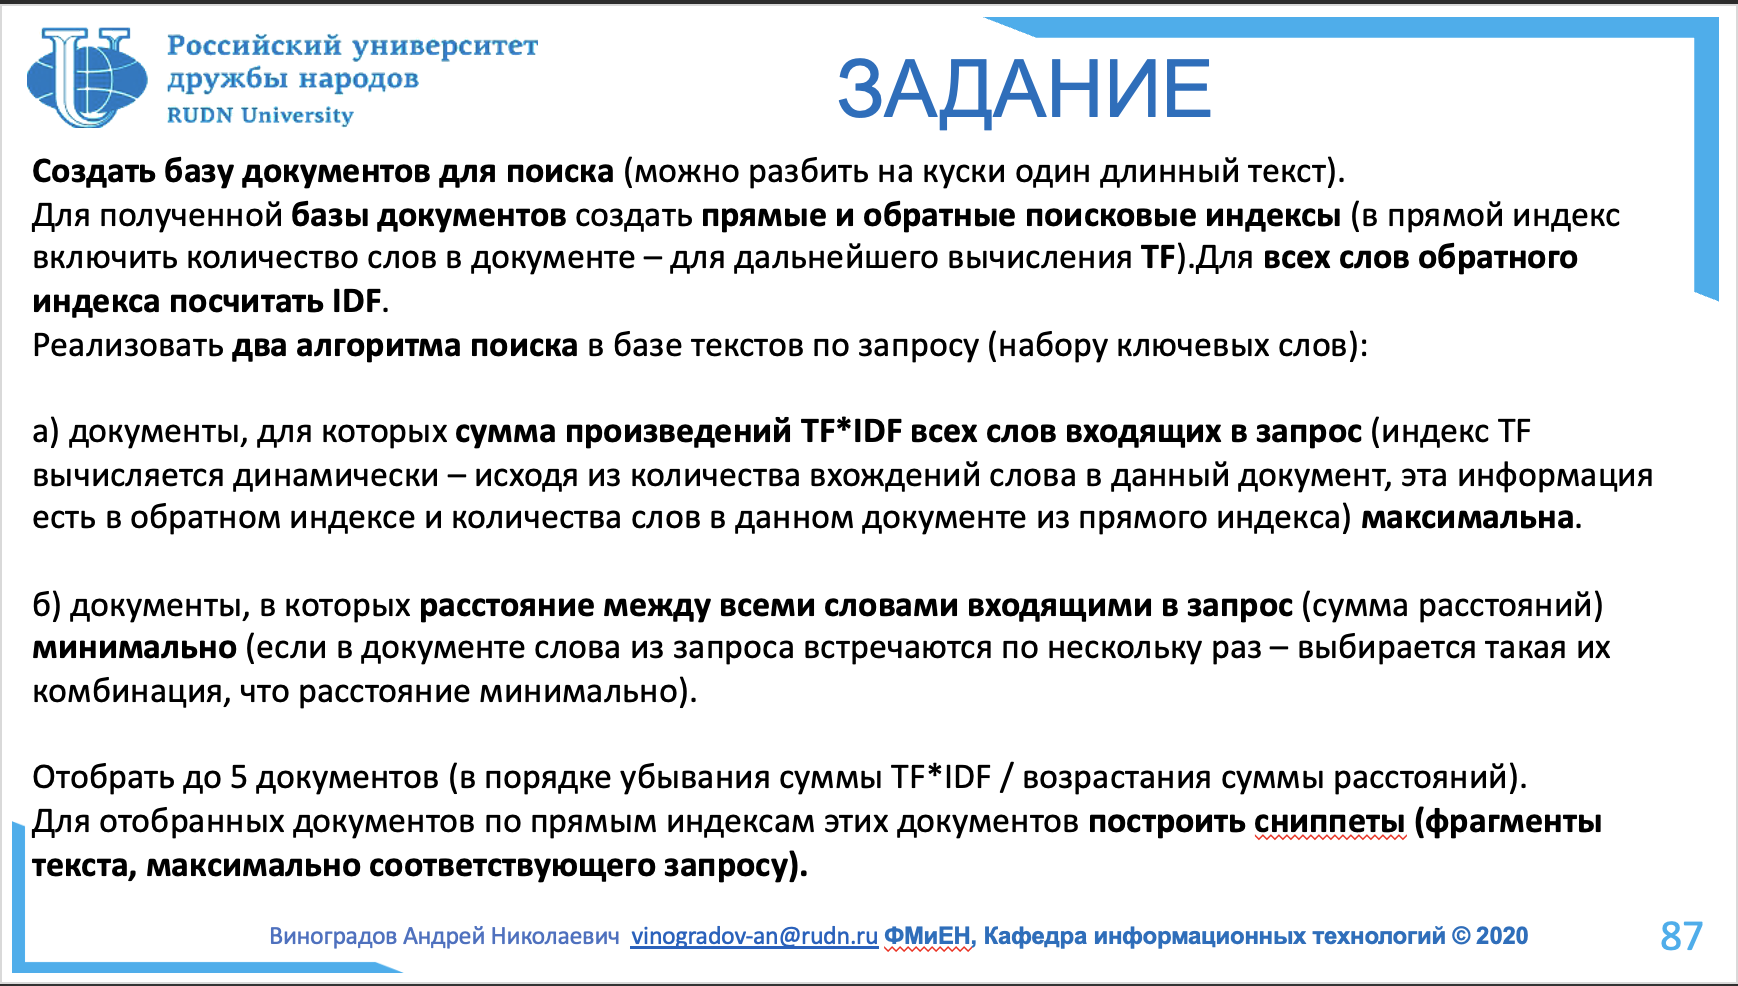

## Выполнение: 

### 1. Подготовка: 

In [80]:
import re
import math
from collections import defaultdict, Counter
from itertools import permutations, combinations
from typing import List, Dict

### 2. Реализуем класс  

In [100]:
import re
import math
from collections import defaultdict, Counter
from itertools import product
from typing import List, Dict, Tuple, Optional, DefaultDict


class SearchEngine:
    def __init__(self) -> None:
        self.documents: List[str] = []
        self.forward_index: Dict[int, Dict[str, int]] = {}
        self.inverse_index: Dict[str, Dict[int, int]] = {}
        self.idf: Dict[str, float] = {}

    def create_documents(self, text: str) -> None:
        sentences = text.strip().split('\n')
        self.documents = [s.strip() for s in sentences if s.strip()]
        
        print(f"Создано {len(self.documents)} документов:")
        for i, doc in enumerate(self.documents, 1):
            print(f"Документ {i}: {doc[:50]}...")
        print()

    def preprocess_text(self, text: str) -> List[str]:
        text = text.lower()
        text = re.sub(r'[^\w\s-]', '', text)
        words = re.findall(r'\b[\w-]+\b', text)
        return words

    def build_forward_index(self) -> None:
        for doc_id, text in enumerate(self.documents):
            words = self.preprocess_text(text)
            word_counts = Counter(words)
            self.forward_index[doc_id] = {
                'words': dict(word_counts),
                'total_words': len(words)
            }
        
        print("Прямой индекс построен:")
        for doc_id, data in self.forward_index.items():
            print(f"Документ {doc_id + 1}: {data['total_words']} слов")
        print()

    def build_inverse_index(self) -> None:
        for doc_id, data in self.forward_index.items():
            for word, count in data['words'].items():
                if word not in self.inverse_index:
                    self.inverse_index[word] = {}
                self.inverse_index[word][doc_id] = count
        
        print("Обратный индекс построен (первые 10 слов):")
        for i, (word, docs) in enumerate(list(self.inverse_index.items())[:10]):
            print(f"{word}: {docs}")
        print()

    def calculate_idf(self) -> None:
        N = len(self.documents)
        
        for word, docs in self.inverse_index.items():
            n_w = len(docs)
            self.idf[word] = math.log(N / n_w) if n_w > 0 else 0
        
        print("IDF для некоторых слов:")
        sample_words = ['машинное', 'обучение', 'нейронные', 'глубокое', 'данные']
        for word in sample_words:
            if word in self.idf:
                print(f"{word}: {self.idf[word]:.4f}")
        print()

    def search_tfidf(self, query_terms: List[str], top_k: int = 5) -> List[Tuple[int, float]]:
        results: List[Tuple[int, float]] = []
        
        for doc_id in range(len(self.documents)):
            tfidf_sum = 0.0
            doc_data = self.forward_index[doc_id]
            
            for term in query_terms:
                if term in doc_data['words'] and term in self.idf:
                    tf = doc_data['words'][term] / doc_data['total_words']
                    tfidf = tf * self.idf[term]
                    tfidf_sum += tfidf
            
            if tfidf_sum > 0:
                results.append((doc_id, tfidf_sum))
        
        results.sort(key=lambda x: x[1], reverse=True)
        return results[:top_k]

    def find_min_distance(self, query_terms: List[str], doc_id: int) -> float:
        text = self.documents[doc_id]
        words = self.preprocess_text(text)
        
        positions: DefaultDict[str, List[int]] = defaultdict(list)
        for i, word in enumerate(words):
            if word in query_terms:
                positions[word].append(i)
        
        if len(positions) != len(query_terms):
            return float('inf')
        
        word_lists = [positions[word] for word in query_terms]
        min_distance = float('inf')
        
        # Оптимизация для 3 слов
        if len(query_terms) == 3:
            word1, word2, word3 = query_terms
            for p1 in positions[word1]:
                for p2 in positions[word2]:
                    for p3 in positions[word3]:
                        dist = abs(p1 - p2) + abs(p1 - p3) + abs(p2 - p3)
                        if dist < min_distance:
                            min_distance = dist
        else:
            for combo in product(*word_lists):
                dist = sum(abs(combo[i] - combo[j]) 
                          for i in range(len(combo)) 
                          for j in range(i+1, len(combo)))
                if dist < min_distance:
                    min_distance = dist
        
        return min_distance

    def search_min_distance(self, query_terms: List[str], top_k: int = 5) -> List[Tuple[int, int]]:
        results: List[Tuple[int, int]] = []
        
        for doc_id in range(len(self.documents)):
            distance = self.find_min_distance(query_terms, doc_id)
            if distance < float('inf'):
                results.append((doc_id, int(distance)))
        
        results.sort(key=lambda x: x[1])
        return results[:top_k]

    def generate_snippet(self, doc_id: int, query_terms: List[str], context_words: int = 5) -> str:
        text = self.documents[doc_id]
        words = self.preprocess_text(text)
        
        positions: List[int] = []
        for i, word in enumerate(words):
            if word in query_terms:
                positions.append(i)
        
        if not positions:
            return text[:100] + "..."
        
        min_pos = max(0, min(positions) - context_words)
        max_pos = min(len(words), max(positions) + context_words + 1)
        
        snippet_words: List[str] = []
        for i in range(min_pos, max_pos):
            word = words[i]
            snippet_words.append(f"[{word}]" if word in query_terms else word)
        
        snippet = " ".join(snippet_words)
        
        if min_pos > 0:
            snippet = "..." + snippet
        if max_pos < len(words):
            snippet = snippet + "..."
        
        return snippet

    def process_query(self, query_text: str) -> None:
        query_terms = self.preprocess_text(query_text)
        
        print(f"Поисковый запрос: '{query_text}'")
        print(f"Ключевые слова: {query_terms}")
        print()
        
        print("\nРЕЗУЛЬТАТЫ ПОИСКА ПО TF-IDF (по убыванию релевантности):\n")
        
        tfidf_results = self.search_tfidf(query_terms)
        for rank, (doc_id, score) in enumerate(tfidf_results, 1):
            print(f"\n{rank}. Документ {doc_id + 1}")
            print(f"   TF-IDF сумма: {score:.6f}")
            snippet = self.generate_snippet(doc_id, query_terms)
            print(f"   Сниппет: {snippet}")
        
        print("\nРЕЗУЛЬТАТЫ ПОИСКА ПО МИНИМАЛЬНОМУ РАССТОЯНИЮ:\n")
        
        dist_results = self.search_min_distance(query_terms)
        for rank, (doc_id, distance) in enumerate(dist_results, 1):
            print(f"\n{rank}. Документ {doc_id + 1}")
            print(f"   Сумма расстояний: {distance}")
            snippet = self.generate_snippet(doc_id, query_terms)
            print(f"   Сниппет: {snippet}")
        
        print("\nСТАТИСТИКА:\n")
        print(f"Всего документов: {len(self.documents)}")
        print(f"Уникальных слов в индексе: {len(self.inverse_index)}")

### 3. Создадим произвольный текст: 

In [101]:
long_text = """
        Машинное обучение — это область искусственного интеллекта, изучающая методы построения алгоритмов, способных обучаться на данных.
        Глубокое обучение — это подраздел машинного обучения, использующий многослойные нейронные сети. 
        Нейронные сети состоят из слоёв нейронов. Каждый нейрон выполняет простые вычисления.
        Обратное распространение ошибки — ключевой алгоритм обучения нейронных сетей. 
        Для обучения нужны большие объёмы данных и вычислительные ресурсы.
        Применяется глубокое обучение в компьютерном зрении, обработке естественного языка, распознавании речи. 
        Машинное обучение также включает обучение с учителем, без учителя и с подкреплением. 
        Кластеризация — пример обучения без учителя.
        Алгоритмы машинного обучения используются в рекомендательных системах, финансах, медицине. 
        Важным этапом является предобработка данных. Качество данных влияет на результат обучения.
        """

### 4. Проверим работоспособность класса:

#### 4.1. Создание экземляра класса: 

In [102]:
engine = SearchEngine()

#### 4.1. Создание базы документов

In [103]:
engine.create_documents(long_text)

Создано 10 документов:
Документ 1: Машинное обучение — это область искусственного инт...
Документ 2: Глубокое обучение — это подраздел машинного обучен...
Документ 3: Нейронные сети состоят из слоёв нейронов. Каждый н...
Документ 4: Обратное распространение ошибки — ключевой алгорит...
Документ 5: Для обучения нужны большие объёмы данных и вычисли...
Документ 6: Применяется глубокое обучение в компьютерном зрени...
Документ 7: Машинное обучение также включает обучение с учител...
Документ 8: Кластеризация — пример обучения без учителя....
Документ 9: Алгоритмы машинного обучения используются в рекоме...
Документ 10: Важным этапом является предобработка данных. Качес...



#### 4.3. Построение прямого индекса

In [104]:
engine.build_forward_index()

Прямой индекс построен:
Документ 1: 14 слов
Документ 2: 10 слов
Документ 3: 11 слов
Документ 4: 8 слов
Документ 5: 9 слов
Документ 6: 11 слов
Документ 7: 12 слов
Документ 8: 5 слов
Документ 9: 9 слов
Документ 10: 11 слов



#### 4.4. Построение обратного индекса

In [105]:
engine.build_inverse_index()

Обратный индекс построен (первые 10 слов):
машинное: {0: 1, 6: 1}
обучение: {0: 1, 1: 1, 5: 1, 6: 2}
это: {0: 1, 1: 1}
область: {0: 1}
искусственного: {0: 1}
интеллекта: {0: 1}
изучающая: {0: 1}
методы: {0: 1}
построения: {0: 1}
алгоритмов: {0: 1}



#### 4.5. Расчет IDF

In [106]:
engine.calculate_idf()

IDF для некоторых слов:
машинное: 1.6094
обучение: 0.9163
нейронные: 1.6094
глубокое: 1.6094



#### 4.6. Выполнение поисковых запросов

In [110]:
query = "машинное обучение нейронные"
engine.process_query(query)

Поисковый запрос: 'машинное обучение нейронные'
Ключевые слова: ['машинное', 'обучение', 'нейронные']


РЕЗУЛЬТАТЫ ПОИСКА ПО TF-IDF (по убыванию релевантности):


1. Документ 7
   TF-IDF сумма: 0.286835
   Сниппет: [машинное] [обучение] также включает [обучение] с учителем без учителя и...

2. Документ 2
   TF-IDF сумма: 0.252573
   Сниппет: глубокое [обучение] это подраздел машинного обучения использующий многослойные [нейронные] сети

3. Документ 1
   TF-IDF сумма: 0.180409
   Сниппет: [машинное] [обучение] это область искусственного интеллекта изучающая...

4. Документ 3
   TF-IDF сумма: 0.146313
   Сниппет: [нейронные] сети состоят из слоёв нейронов...

5. Документ 6
   TF-IDF сумма: 0.083299
   Сниппет: применяется глубокое [обучение] в компьютерном зрении обработке естественного...

РЕЗУЛЬТАТЫ ПОИСКА ПО МИНИМАЛЬНОМУ РАССТОЯНИЮ:


СТАТИСТИКА:

Всего документов: 10
Уникальных слов в индексе: 76


In [111]:
query = "глубокое обучение данные"
engine.process_query(query)

Поисковый запрос: 'глубокое обучение данные'
Ключевые слова: ['глубокое', 'обучение', 'данные']


РЕЗУЛЬТАТЫ ПОИСКА ПО TF-IDF (по убыванию релевантности):


1. Документ 2
   TF-IDF сумма: 0.252573
   Сниппет: [глубокое] [обучение] это подраздел машинного обучения использующий...

2. Документ 6
   TF-IDF сумма: 0.229612
   Сниппет: применяется [глубокое] [обучение] в компьютерном зрении обработке естественного...

3. Документ 7
   TF-IDF сумма: 0.152715
   Сниппет: машинное [обучение] также включает [обучение] с учителем без учителя и...

4. Документ 1
   TF-IDF сумма: 0.065449
   Сниппет: машинное [обучение] это область искусственного интеллекта изучающая...

РЕЗУЛЬТАТЫ ПОИСКА ПО МИНИМАЛЬНОМУ РАССТОЯНИЮ:


СТАТИСТИКА:

Всего документов: 10
Уникальных слов в индексе: 76


## Вывод:

На данной лабораторной работе мы научились пользоваться TF (Term Frequency) и IDF(Inverse Document Frequency) и реализовали простой поисковый движок